# Practical 3

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt  # needed later on

ModuleNotFoundError: No module named 'cvxopt'

# Task 0: Preliminaries

This time we will work with a synthetic 2d dataset to facilitate visualization and be able to focus on the algorithms rather than spending energy to understand the dataset. The dataset consists of two classes and two predictors. Below we load the dataset and plot it.

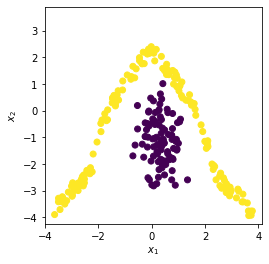

In [3]:
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:, :2], np.load('nonlin_2d_data.npy')[:, 2]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square');

### Task 0.1

Apply logistic regression and LDA to the provided data, compute classification accuracy and plot the predictions. How do they perform? You're welcome to use sklearn for this task.

In [28]:
X_2d.shape

(250, 2)

In [4]:
# Split data in training and test set
np.random.seed(42)
train_size = int(len(X_2d)*0.8)
trainX, trainY = X_2d[np.random.choice(len(X_2d), train_size, replace=False)], t_2d[np.random.choice(len(X_2d), train_size, replace=False)]
testX, testY = X_2d[list(set(range(len(X_2d)))- set(np.random.choice(len(X_2d), train_size, replace=False)))], t_2d[list(set(range(len(X_2d)))- set(np.random.choice(len(X_2d), train_size, replace=False)))]



In [5]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(trainX, trainY)
clf.score(testX,testY)

0.6

In [6]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis().fit(trainX,trainY)
clf.score(testX,testY)


0.6

### Task 0.2

Implement the Gaussian RBF and visualize the pairwise similarities of `x`.

In [7]:
x = np.stack([np.sin(np.linspace(0, 8, 15)), np.cos(np.linspace(0, 7, 15))]).T

In [12]:
# RBF kernel
import math
def rbfkernal(X1,X2,gamma=1):
  x22 = list(X2)
  X2 = np.array([x22] * 15)
  X2 = X2.squeeze()
  s = []
  for i in X1:
    s.append(list(np.full(15, i)))
  k1 = np.array(s)
  k = np.power((k1 - X2),2)
  # k = k - np.abs(2 * np.mat(X1) * np.mat(X2).T)

  return np.exp((-1* gamma* k))


In [46]:
rbf= rbfkernal
rbf

array([[0.36787944, 0.46294309, 0.74682336, 0.99500875, 0.84098775,
        0.52632779, 0.37527914, 0.41604946, 0.65230047, 0.9565379 ,
        0.9226879 , 0.60518998, 0.39775184, 0.38530371, 0.56644878],
       [0.80990913, 0.89279396, 0.99999972, 0.80172374, 0.40019125,
        0.16514944, 0.09599776, 0.11277186, 0.24008139, 0.56838989,
        0.9360022 , 0.97222427, 0.83874987, 0.82705752, 0.95561708],
       [0.99190107, 0.9989611 , 0.87236664, 0.49457087, 0.17235555,
        0.05353571, 0.02707083, 0.03308258, 0.08677579, 0.28485178,
        0.67565191, 0.96034509, 0.99746835, 0.99555239, 0.97598189],
       [0.99989439, 0.98750325, 0.81711208, 0.42975715, 0.13855746,
        0.04046963, 0.01985551, 0.0244734 , 0.06716157, 0.23663285,
        0.60742781, 0.92404829, 0.99912702, 0.99982748, 0.9459066 ],
       [0.94180882, 0.98512134, 0.95489084, 0.62599255, 0.25361718,
        0.08874035, 0.04757195, 0.0571816 , 0.13742306, 0.39335391,
        0.80067676, 0.9978422 , 0.95883666, 

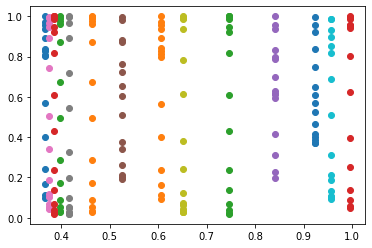

In [18]:
# Visualize pairwise similarities
for xa, ya in zip(r[:][0], r[:][1:]):
    plt.scatter([xa] * len(ya), ya)

# Task 1: Kernel Discriminant Analysis

We will be implementing Kernel Discriminant Analysis, a nonlinear extension to LDA based on the kernel trick, following the original paper by Mika, Rätsch, Weston, Schölkopf and Müller (PDF on StudIP). Note, this is the original notation from the paper, mind the difference betweeen the matrix $M$ and the vectors $M_1, M_2$.

The goal of Kernel Discriminant Analysis is find a vector of $\alpha$'s that maximizes
$$ J(\alpha) = \frac{\alpha^T M \alpha}{\alpha^T N \alpha} $$
where
$$M := (M_1 - M_2)(M_1 - M_2)^T \text{ with } (M_i)_j = \frac{1}{l_i} \sum_{k=1}^{l_i} \mbox{k}(x_j, x_k^i)$$ and
$$N= \sum_{j=1,2} K_j (I - 1_{l_j}) K_j^T$$
Here, the number of samples for class $j$ is denoted by $l_j$. In the definition of $N$, $(K_{j})_{n,m} = \mbox{k}(x_n, x_m^j)$, $I$ is the identity matrix and $1_{l_j}$ is a matrix with each entry equal to $1/l_j$. $M_1, M_2$ have shape $(l_0 + l_1)$ each, $N$ and $M$ have shape $(l_0 + l_1) \times (l_0 + l_1)$.

We obtain the optimal solution by $\alpha = N^{-1}(M_1 - M_0)$. Note that you may have to regularize $N^{-1}$ for numerical stability (see paper or Wikipedia).

Prediction for an arbitrary sample $x$ is then carried out by building a weighted sum over it's kernel with the samples from the training set.

1. Implement a function `kda(X, t, kernel)` that carries out Kernel Discriminant Analysis on the data $X,t$ and returns a vector `alpha`.
2. Implement a function `def predict(x, X, alpha, kernel)`.
3. Visualize results given a linear kernel and a Gaussian Radial Basis Function kernel.

Use the following snippet as a starting point.

In [64]:
def inv(m):
    a, b = m.shape
    if a != b:
        raise ValueError("Only square matrices are invertible.")

    i = np.eye(a, a)
    return np.linalg.lstsq(m, i, rcond=None)[0]



In [79]:
def kda(X, t, kernel):
    if kernel == 'rbf':
        kernel = lambda x, y: np.exp(-0.01*np.sum((y-x[:, np.newaxis])**2, axis=-1))
    else:
        kernel = lambda x, y: np.dot(x, y.T)
    
    l = [(t == 0).sum(), (t == 1).sum()]

    X_split = X[(t == 0)], X[(t == 1)]

    M = np.ones((2, len(X)))

    for i in range(len(X_split[0])):
        M[0][i] = np.sum(kernel(X_split[0][i], X_split[0][i]))
    M[0] = 1/l[0] * M[0]


    for i in range(len(X_split[1])):
        M[1][i] = np.sum(kernel(X_split[1][i], X_split[1][i]))
    M[1] = 1/l[1] * M[1]

    K = np.ones((len(X), l[0])), np.ones((len(X), l[1]))

    k0 = kernel(X_split[0], X_split[0])
    k0 = np.pad(k0, ((0,len(X)-len(k0)),(0,len(X)-len(k0))))

    k1 = kernel(X_split[1], X_split[1])
    k1 = np.pad(k1, ((0,len(X)-len(k1)),(0,len(X)-len(k1))))

    Nj0 = np.dot(np.dot((np.identity(len(X)) - np.full(len(X)*len(X),
                 1/l[0]).reshape(len(X), len(X))), k0), k0.T)

    Nj1 = np.dot(np.dot((np.identity(len(X)) - np.full(len(X)*len(X),
                 1/l[1]).reshape(len(X), len(X))), k1) ,k1.T)

    N = (Nj0 + Nj1) * 0.0001
    M_d= (M[1] - M[0])
    alpha = np.dot(inv(N), M_d)

    return alpha

def predict(x, X, alpha, kernel):
    # ...
    pass


def linear_kernel(x_n, x_m):
    x22 = list(x_m)
    X2 = np.array([x22] * len(x_n))
    X2 = X2.squeeze()
    s = []
    for i in x_n:
      s.append(list(np.full(len(x_n), i)))
    k1 = np.array(s)
    return np.dot(np.transpose(k1), X2)
    

def rbf_kernel(x_n, x_m, gamma=5):
    # ...
    x22 = list(x_m)
    X2 = np.array([x22] * len(x_n))
    X2 = X2.squeeze()
    s = []
    for i in x_n:
      s.append(list(np.full(len(x_n), i)))
    k1 = np.array(s)
    k = np.power((k1 - X2),2)
    # k = k - np.abs(2 * np.mat(X1) * np.mat(X2).T)
    return np.exp((-1* gamma* k))

In [83]:
# Perform KDA with linear and RBF kernel
lf = linear_kernel(x[:,0].reshape(15,1),x[:,1].reshape(15,1))
kda_1= kda(trainX, trainY, rbf)
kda_2= kda(trainX, trainY, lf)
rbf


/var/folders/j4/rz_vddh97qx2fg3073flhykw0000gn/T/ipykernel_36796/2546243104.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kernel == 'rbf':


array([[1.87200969e-11, 5.00334352e-18, 3.36545980e-09, ...,
        5.43950870e-23, 4.89090797e-03, 1.76894947e-05],
       [5.29401758e-06, 7.59614879e-11, 1.84232824e-04, ...,
        1.02530735e-14, 5.72900980e-07, 3.59761887e-02],
       [6.89625688e-03, 2.86703410e-06, 5.99049379e-02, ...,
        3.25289307e-09, 8.76832471e-12, 7.23614672e-01],
       ...,
       [9.64805785e-28, 1.02877483e-37, 4.37004612e-24, ...,
        7.92585047e-45, 6.88942725e-01, 1.48276899e-17],
       [3.46248581e-06, 4.22505421e-11, 1.28818426e-04, ...,
        5.14748166e-15, 9.02271915e-07, 2.87603319e-02],
       [9.86177007e-02, 9.67962572e-01, 1.34879346e-02, ...,
        6.40081125e-01, 2.39069954e-34, 3.95262121e-05]])

In [ ]:
# Visualize results


### Task 1.2

Which value would you use as a threshold to separate the classes? Use this threshold value to visualize the decision boundaries in a 2d grid (see example code below) and make predictions on the test set.

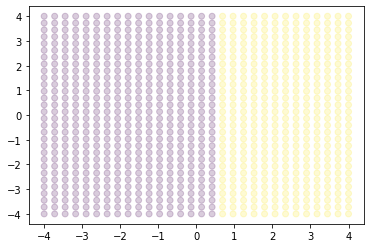

In [ ]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn([x, y]) for x, y, in zip(grid_x, grid_y)])
    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)


# The following example has the decision boundary at x[0] = 0.5
predict_fn = lambda x: x[0] > 0.5
plot_decision_boundary(predict_fn)

In [ ]:
# Visualize decision boundaries
